# CIFAR10 with Daisy and ResNet features (pytorch / skimage / sklearn)

In [1]:
# Remember to select a GPU runtime when setting this to True
USE_CUDA = False

## Download and uncompress the dataset


In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.feature import daisy
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pickle
from tqdm import tqdm
import wget
import tarfile
import os

In [3]:
data_url = r'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
download_path = './data/cifar-10-python.tar.gz'
uncompressed_path = './data/cifar-10-python'
batches_subdir = 'cifar-10-batches-py'
batches_path = os.path.join(uncompressed_path, batches_subdir)

os.makedirs(os.path.dirname(download_path), exist_ok=True)

print('Downloading...')
wget.download(data_url, download_path)

print('Uncompressing...')
with tarfile.open(download_path, "r:gz") as tar:
    tar.extractall(uncompressed_path)
    
print('Uncompressed batches: {}'.format(', '.join(os.listdir(batches_path))))
print('Data ready!')

Downloading...
Uncompressing...
Uncompressed batches: data_batch_1, readme.html, batches.meta, data_batch_2, data_batch_5, test_batch, data_batch_4, data_batch_3
Data ready!


## Load the data into memory and format it as a stack of RGB images

In [4]:
def load_batch(batches_path, batch_name):
   with open(os.path.join(batches_path, batch_name), 'rb') as f:
       data_batch = pickle.load(f, encoding='bytes')
   return data_batch

In [5]:
def data_to_images(data):
    data_reshp = np.reshape(data, (-1, 3, 32, 32))
    imgs = np.moveaxis(data_reshp, (1, 2, 3), (3, 1, 2))
    return imgs

In [6]:
def batches_to_images_with_labels(batches):
    data_table = np.concatenate([batch[b'data'] for batch in batches], axis=0)
    labels = np.concatenate([np.asarray(batch[b'labels']) for batch in batches])
    images = data_to_images(data_table)
    return images, labels

In [7]:
train_batch_names = ['data_batch_{}'.format(i) for i in range(1, 5)]
val_batch_names = ['data_batch_5']
test_batch_names = ['test_batch']

In [8]:
train_batches = [load_batch(batches_path, batch_name) for batch_name in train_batch_names]
train_imgs, train_labels = batches_to_images_with_labels(train_batches)
print('Training set: Images shape = {}'.format(train_imgs.shape))
print('Training set: Labels shape = {}'.format(train_labels.shape))
print()
val_batches = [load_batch(batches_path, batch_name) for batch_name in val_batch_names]
val_imgs, val_labels = batches_to_images_with_labels(val_batches)
print('Validation set: Images shape = {}'.format(val_imgs.shape))
print('Validation set: Labels shape = {}'.format(val_labels.shape))
print()
test_batches = [load_batch(batches_path, batch_name) for batch_name in test_batch_names]
test_imgs, test_labels = batches_to_images_with_labels(test_batches)
print('Test set: Images shape = {}'.format(test_imgs.shape))
print('Test set: Labels shape = {}'.format(test_labels.shape))

Training set: Images shape = (40000, 32, 32, 3)
Training set: Labels shape = (40000,)

Validation set: Images shape = (10000, 32, 32, 3)
Validation set: Labels shape = (10000,)

Test set: Images shape = (10000, 32, 32, 3)
Test set: Labels shape = (10000,)


## Display some random images from the training set

In [9]:
grid_num_rows = 10
grid_num_cols = 10
num_random_samples = grid_num_rows * grid_num_cols

In [10]:
def display_random_subset(imgs, labels, grid_num_rows=6, grid_num_cols=6, figsize=(12, 12)):
    fig, ax_objs = plt.subplots(nrows=grid_num_rows, ncols=grid_num_cols, figsize=figsize)
    for ax in np.ravel(ax_objs):
        rnd_id = np.random.randint(labels.shape[0])
        img = train_imgs[rnd_id]
        label = labels[rnd_id]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('{}'.format(label))

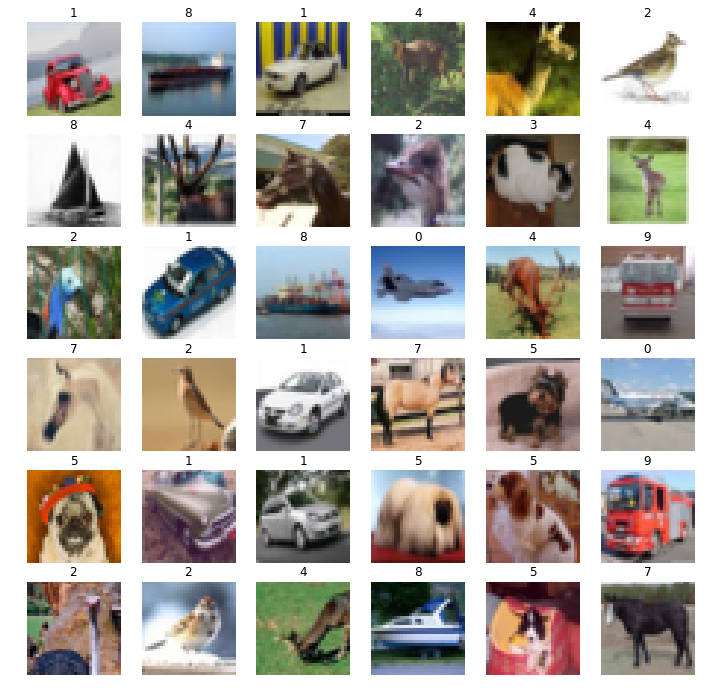

In [11]:
display_random_subset(train_imgs, train_labels)

## Shallow baseline

In [12]:
def extract_daisy_features(images):
    feature_vecs = []
    for img in tqdm(images):
        img_grayscale = np.mean(img, axis=2)
        fvec = daisy(img_grayscale, step=4, radius=9).reshape(1, -1)
        feature_vecs.append(fvec)
    return np.concatenate(feature_vecs)

In [13]:
train_daisy_feature_vecs = extract_daisy_features(train_imgs)
val_daisy_feature_vecs = extract_daisy_features(val_imgs)
test_daisy_feature_vecs = extract_daisy_features(test_imgs)

100%|██████████| 10000/10000 [02:02<00:00, 81.69it/s]


In [14]:
print('Training set: Daisy features shape = {}'.format(train_daisy_feature_vecs.shape))
print('Training set: labels shape = {}'.format(train_labels.shape))
print()
print('Validation set: Daisy features shape = {}'.format(val_daisy_feature_vecs.shape))
print('Validation set: labels shape = {}'.format(val_labels.shape))
print()
print('Test set: Daisy features shape = {}'.format(test_daisy_feature_vecs.shape))
print('Test set: labels shape = {}'.format(test_labels.shape))

Training set: Daisy features shape = (40000, 3200)
Training set: labels shape = (40000,)

Validation set: Daisy features shape = (10000, 3200)
Validation set: labels shape = (10000,)

Test set: Daisy features shape = (10000, 3200)
Test set: labels shape = (10000,)


In [15]:
daisy_svm_param_grid = {'C': np.logspace(-4, 4, num=9, endpoint=True, base=10)}
daisy_clf = GridSearchCV(estimator=LinearSVC(), param_grid=daisy_svm_param_grid, cv=3, n_jobs=4, verbose=10)
daisy_clf.fit(X=train_daisy_feature_vecs, y=train_labels)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=0.0001 ........................................................
[CV] C=0.0001 ........................................................
[CV] C=0.0001 ........................................................
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.3523545290941812, total= 3.4min
[CV] C=0.001 .........................................................
[CV] ............... C=0.0001, score=0.2752231640537094, total= 3.8min
[CV] ............... C=0.0001, score=0.2793819845496137, total= 3.9min
[CV] .............. C=0.0001, score=0.28141871625674864, total= 3.9min
[CV] C=0.001 .........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] ............... C=0.001, score=0.35143650138774285, total= 3.3min
[CV] C=0.01 .....

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  7.7min


[CV] ................ C=0.001, score=0.3588089702242556, total= 3.6min
[CV] C=0.1 ...........................................................
[CV] ................ C=0.01, score=0.37889922015596883, total= 5.9min
[CV] C=0.1 ...........................................................
[CV] ................ C=0.01, score=0.38978474461861545, total= 5.8min
[CV] C=0.1 ...........................................................
[CV] ................. C=0.01, score=0.3758907808866552, total= 5.0min
[CV] .................. C=0.1, score=0.4409118176364727, total= 4.8min
[CV] C=1.0 ...........................................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 12.8min


[CV] C=1.0 ...........................................................
[CV] .................. C=0.1, score=0.4513612840321008, total= 5.0min
[CV] C=1.0 ...........................................................
[CV] ................. C=0.1, score=0.43537619083339585, total= 4.8min
[CV] C=10.0 ..........................................................
[CV] .................. C=1.0, score=0.5050989802039592, total= 6.9min
[CV] C=10.0 ..........................................................
[CV] .................. C=1.0, score=0.5104627615690392, total= 6.7min
[CV] C=10.0 ..........................................................
[CV] ................... C=1.0, score=0.502287900382567, total= 4.5min
[CV] C=100.0 .........................................................
[CV] ................. C=10.0, score=0.5586382723455309, total=17.3min
[CV] C=100.0 .........................................................
[CV] ................. C=10.0, score=0.5595889897247431, total=15.9min
[CV] C

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 35.8min


[CV] ................. C=10.0, score=0.5507463806166079, total=15.7min
[CV] C=1000.0 ........................................................
[CV] ................ C=100.0, score=0.5879574085182964, total=47.3min
[CV] C=1000.0 ........................................................
[CV] ................. C=100.0, score=0.582689567239181, total=45.2min
[CV] C=1000.0 ........................................................
[CV] ................ C=100.0, score=0.5774510539344385, total=44.8min
[CV] C=10000.0 .......................................................
[CV] ............... C=1000.0, score=0.5617126574685063, total=56.0min
[CV] C=10000.0 .......................................................
[CV] ............... C=1000.0, score=0.5058126453161329, total=56.4min
[CV] C=10000.0 .......................................................


[Parallel(n_jobs=4)]: Done  23 out of  27 | elapsed: 124.2min remaining: 21.6min


[CV] ............... C=1000.0, score=0.5214162478433726, total=56.6min
[CV] ............... C=10000.0, score=0.249250149970006, total=56.6min
[CV] ............. C=10000.0, score=0.19380484512112803, total=51.3min
[CV] .............. C=10000.0, score=0.5271172455179657, total=36.8min


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 161.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [16]:
val_daisy_predictions = daisy_clf.predict(X=val_daisy_feature_vecs)
val_daisy_accuracy = np.mean(val_daisy_predictions == val_labels)
print('Validation Daisy accuracy = {} (use this to tune params)'.format(val_daisy_accuracy))

Validation Daisy accuracy = 0.5959 (use this to tune params)


In [17]:
test_daisy_predictions = daisy_clf.predict(X=test_daisy_feature_vecs)
test_daisy_accuracy = np.mean(test_daisy_predictions == test_labels)
print('Test Daisy accuracy = {} (DO NOT use this to tune params!)'.format(test_daisy_accuracy))

Test Daisy accuracy = 0.5953 (DO NOT use this to tune params!)


## ResNet feature extraction

In [18]:
r50 = torchvision.models.resnet50(pretrained=True)

# Throw away the classification layer and pooling layer before it (not needed
# because images are small anyway)
r50_fx_layers = list(r50.children())[:-2]
r50_fx = torch.nn.Sequential(*r50_fx_layers)

In [19]:
def extract_deep_features(images, model, use_cuda, batch_size=128):
  
    # Normalize for torchvision
    torchvision_mean = np.array([0.485, 0.456, 0.406])
    torchvision_std = np.array([0.485, 0.456, 0.406])
    images_norm = (images / 255. - torchvision_mean) / torchvision_std
    images_norm_tensor = torch.from_numpy(images_norm.astype(np.float32)).permute((0, 3, 2, 1))
    
    dset = torch.utils.data.TensorDataset(images_norm_tensor)
    dataloader = torch.utils.data.DataLoader(dset, batch_size, shuffle=False, drop_last=False)
    model.eval()
    if use_cuda:
        model.cuda()
            
    feature_vec_batches = []
    with tqdm(total=len(dataloader)) as pbar:
        for data_batch in dataloader:
            img_batch = data_batch[0]  # We get a tuple so have to unpack it
            if use_cuda:
                img_batch = img_batch.cuda()
            fvec_batch = model(img_batch)
            if use_cuda:
                fvec_batch = fvec_batch.cpu()
            fvec_batch_cl = fvec_batch.detach().clone()
            fvec_batch_np = fvec_batch_cl.view(img_batch.size(0), -1).numpy()
            feature_vec_batches.append(fvec_batch_np)
            pbar.update(1)
        
    if use_cuda:
        model.cpu()  # cleanup
    
    return np.concatenate(feature_vec_batches, axis=0)

In [20]:
train_resnet_feature_vecs = extract_deep_features(train_imgs, r50_fx, use_cuda=USE_CUDA)
val_resnet_feature_vecs = extract_deep_features(val_imgs, r50_fx, use_cuda=USE_CUDA)
test_resnet_feature_vecs = extract_deep_features(test_imgs, r50_fx, use_cuda=USE_CUDA)

100%|██████████| 79/79 [02:13<00:00,  1.28s/it]


In [21]:
print('Training set: ResNet features shape = {}'.format(train_resnet_feature_vecs.shape))
print('Training set: labels shape = {}'.format(train_labels.shape))
print()
print('Validation set: ResNet features shape = {}'.format(val_resnet_feature_vecs.shape))
print('Validation set: labels shape = {}'.format(val_labels.shape))
print()
print('Test set: ResNet features shape = {}'.format(test_resnet_feature_vecs.shape))
print('Test set: labels shape = {}'.format(test_labels.shape))

Training set: ResNet features shape = (40000, 2048)
Training set: labels shape = (40000,)

Validation set: ResNet features shape = (10000, 2048)
Validation set: labels shape = (10000,)

Test set: ResNet features shape = (10000, 2048)
Test set: labels shape = (10000,)


### Visualize the ResNet features

In [22]:
pca = PCA(n_components=50)
embed = TSNE(n_components=2, init='pca')
dim_red = Pipeline([('pca', pca), ('embed', embed)])

dim_red_subset = np.random.choice(np.arange(train_resnet_feature_vecs.shape[0]), size=5000, replace=False)
train_resnet_feature_vecs_subset_dimred = dim_red.fit_transform(train_resnet_feature_vecs[dim_red_subset])
train_labels_subset = train_labels[dim_red_subset]

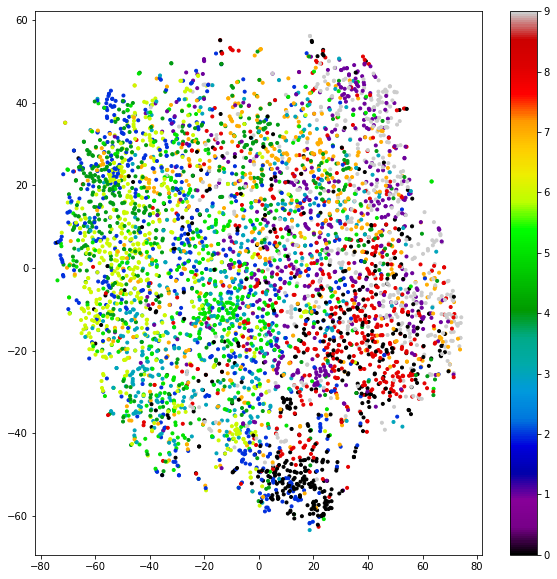

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(train_resnet_feature_vecs_subset_dimred[:, 0],
                train_resnet_feature_vecs_subset_dimred[:, 1],
                c=train_labels_subset, 
                marker='.',
                cmap='nipy_spectral')
plt.colorbar(sc)

### Fit an SVM to ResNet features

In [24]:
resnet_svm_param_grid = {'C': np.logspace(-4, 4, num=9, endpoint=True, base=10)}
resnet_clf = GridSearchCV(estimator=LinearSVC(), param_grid=resnet_svm_param_grid, cv=3, n_jobs=4, verbose=10)
resnet_clf.fit(X=train_resnet_feature_vecs, y=train_labels)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=0.0001 ........................................................
[CV] C=0.0001 ........................................................
[CV] C=0.0001 ........................................................
[CV] C=0.001 .........................................................
[CV] ............... C=0.0001, score=0.6154769046190762, total=  28.0s
[CV] C=0.001 .........................................................
[CV] ............... C=0.0001, score=0.6085652141303532, total=  29.5s
[CV] C=0.001 .........................................................
[CV] ............... C=0.0001, score=0.6148826044557798, total=  29.6s
[CV] C=0.01 ..........................................................
[CV] ................ C=0.001, score=0.6330983803239352, total= 1.4min
[CV] C=0.01 ..........................................................
[CV] ................ C=0.001, score=0.6311604530792889, total= 1.2min
[CV] C=0.01 .....

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.8min


[CV] ................ C=0.001, score=0.6277656941423536, total= 1.3min
[CV] C=0.1 ...........................................................
[CV] ................. C=0.01, score=0.6146520695860828, total= 8.0min
[CV] C=0.1 ...........................................................
[CV] ................. C=0.01, score=0.6037650941273531, total= 8.5min
[CV] C=0.1 ...........................................................
[CV] ................. C=0.01, score=0.6101567774360513, total= 8.7min
[CV] C=1.0 ...........................................................
[CV] .................. C=0.1, score=0.5926064787042592, total=11.1min
[CV] C=1.0 ...........................................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 13.0min


[CV] .................. C=0.1, score=0.5824645616140404, total=11.9min
[CV] C=1.0 ...........................................................
[CV] .................. C=0.1, score=0.5893031280474083, total=12.2min
[CV] C=10.0 ..........................................................
[CV] .................. C=1.0, score=0.5418416316736653, total=14.5min
[CV] C=10.0 ..........................................................
[CV] .................. C=1.0, score=0.5255381384534613, total=13.9min
[CV] C=10.0 ..........................................................
[CV] ................... C=1.0, score=0.546995724251744, total=13.2min
[CV] C=100.0 .........................................................
[CV] ................. C=10.0, score=0.5296940611877624, total=12.9min
[CV] C=100.0 .........................................................
[CV] ................. C=10.0, score=0.5313882847071176, total=12.6min
[CV] C=100.0 .........................................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 37.8min


[CV] ................. C=10.0, score=0.5186407621333733, total=12.9min
[CV] C=1000.0 ........................................................
[CV] ................ C=100.0, score=0.5203209358128374, total=12.9min
[CV] C=1000.0 ........................................................
[CV] ................ C=100.0, score=0.5344633615840396, total=12.6min
[CV] C=1000.0 ........................................................
[CV] ................ C=100.0, score=0.5156402370414822, total=12.9min
[CV] C=10000.0 .......................................................
[CV] ............... C=1000.0, score=0.5242201559688062, total=12.8min
[CV] C=10000.0 .......................................................
[CV] ............... C=1000.0, score=0.5189379734493362, total=12.6min
[CV] C=10000.0 .......................................................


[Parallel(n_jobs=4)]: Done  23 out of  27 | elapsed: 59.3min remaining: 10.3min


[CV] ................ C=1000.0, score=0.520441077188508, total=12.8min
[CV] .............. C=10000.0, score=0.5137222555488902, total=12.3min
[CV] .............. C=10000.0, score=0.5052126303157579, total=11.3min
[CV] .............. C=10000.0, score=0.5398694771585028, total= 8.6min


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 67.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [25]:
val_resnet_predictions = resnet_clf.predict(X=val_resnet_feature_vecs)
val_resnet_accuracy = np.mean(val_resnet_predictions == val_labels)
print('Validation Resnet accuracy = {} (use this to tune params)'.format(val_resnet_accuracy))

Validation Resnet accuracy = 0.6376 (use this to tune params)


In [26]:
test_resnet_predictions = resnet_clf.predict(X=test_resnet_feature_vecs)
test_resnet_accuracy = np.mean(test_resnet_predictions == test_labels)
print('Test Resnet accuracy = {} (DO NOT use this to tune params!)'.format(test_resnet_accuracy))

Test Resnet accuracy = 0.6337 (DO NOT use this to tune params!)
